# Questions per Linux Distribution
This notebook intends to show how many questions are under the tag for each linux distribution on serverfault.com. If access to internet is unavailable or data from disk is preferred, execution may begin with the code cell under the heading "Optional: Load old data from CSV".

# Step 1: get a list of programming languages
We will use the wikipedia page for [list of linux distributions](https://en.wikipedia.org/wiki/List_of_Linux_distributions) as our major source.

In [1]:
#### This cell access the internet ####
# grabs the wikipedia page "list of linux distributions"

WIKIPEDIA_LIST_OF_LINUX_DISTRIBUTIONS = 'https://en.wikipedia.org/wiki/List_of_Linux_distributions'

import requests
from bs4 import BeautifulSoup

with requests.get(WIKIPEDIA_LIST_OF_LINUX_DISTRIBUTIONS) as r:
    distro_list_soup = BeautifulSoup(r.text, 'html.parser')

Next, we scrape for names of linux distributions.

In [2]:
import re

table_rows = distro_list_soup.find_all('tr')

linux_distros = []

for tr in table_rows:
    td = tr.find('td')
    if(td != None):
        a = td.find('a')
        if(a != None and a.text != ''):
            linux_distros.append(a.text)
            
for i in range(len(linux_distros)):
    linux_distros[i] = linux_distros[i].strip()
    
for i in range(len(linux_distros)):
    linux_distros[i] = linux_distros[i].replace(' ', '-')

for i in range(len(linux_distros)):
    linux_distros[i] = linux_distros[i].lower()

# manually removing things that aren't actually linux names and replacing 
# a few things that serverfault treats differently
linux_distros.remove('history')
linux_distros[linux_distros.index('red-hat-linux')] = 'redhat'

# convert to set to remove duplicates
linux_distros = set(linux_distros)

# Step 2: query serverfault for the number of questions having each tag

In [3]:
#### This cell access the internet ####
# scrapes serverfault for searches with tags

import time

SERVERFAULT_TAG_SEARCH_URL_BASE = 'https://serverfault.com/questions/tagged/'
TIME_BETWEEN_REQUESTS = 0.5 # time is in seconds
        
# regular expression for getting number from questions
re_num_questions = re.compile(r'(\d+,?)+' , re.MULTILINE)

linux_distro_stats = []
ld = 'ubuntasdfu'

for ld in linux_distros:
    # stack exchange states that they throttles all IP addresses sending more than 30 
    # requests per second. While writing this notebook, I've been rate limited even
    # when sending only 5 requests per second. Therefore, we will wait a generous
    # amount of time between each request to avoid rate-limiting
    
    time.sleep(TIME_BETWEEN_REQUESTS)
    
    with requests.get(SERVERFAULT_TAG_SEARCH_URL_BASE + ld) as r:
        if r.ok:
            ### create soup from webpage
            serverfault_soup = BeautifulSoup(r.text, 'html.parser')

            ### find div with number of questions
            questions_text = serverfault_soup.find('div', {'class': 'fs-body3 grid--cell fl1 mr12 sm:mr0 sm:mb12'})
            num_questions_match = re_num_questions.search(questions_text.text)
            num_questions_string = num_questions_match.group(0).replace(',', '')
            num_questions = int(num_questions_string)
            #print(num_questions)

            ### find descripition
            description_container = serverfault_soup.find_all('div', {'class': 'mb24'})
            # we are operating under the assumption that the description is the *second* div with 
            # class mb24. THIS MAY CHANGE without notice. We are subject to the whims of 
            # serverfault
            description_container = description_container[1]
            description = description_container.find('p').text
            description = description.replace('\r\n', ' ')
            description = description.replace('\n', ' ')
            description = description.strip()
            #print(description)

            ### put it all into a Distro object that gets added to our list
            linux_distro_stats.append((ld, num_questions, description))
            print('Successfully stored info for questions on tag \'', ld, '\'', sep='')
        else:
            #print('Got status code ', r.status_code, ' while searching for questions with tag \'',
            #      ld, '\'', sep='')
            if(r.status_code == 429):
                print('This IP address has been rate-limited by stack exchange! Please '
                      + 'try again later. You may optionally increase the time between '
                      + 'requests by editing the variable \'TIME_BETWEEN_REQUESTS\'')

Successfully stored info for questions on tag 'smoothwall'
Successfully stored info for questions on tag 'fedora'
Successfully stored info for questions on tag 'opensuse'
Successfully stored info for questions on tag 'chrome-os'
Successfully stored info for questions on tag 'oracle-linux'
Successfully stored info for questions on tag 'devuan'
Successfully stored info for questions on tag 'android'
Successfully stored info for questions on tag 'openwrt'
Successfully stored info for questions on tag 'vyatta'
Successfully stored info for questions on tag 'clearos'
Successfully stored info for questions on tag 'vyos'
Successfully stored info for questions on tag 'scientific-linux'
Successfully stored info for questions on tag 'arch-linux'
Successfully stored info for questions on tag 'nixos'
Successfully stored info for questions on tag 'redhat'
Successfully stored info for questions on tag 'xubuntu'
Successfully stored info for questions on tag 'ubuntu-server'
Successfully stored info for

# Step 3: Store data for later use
In case stack exchange decides to implement more aggressive rate-limiting or dramatically changes their website, it will be handy to have this data saved to disk. Since we're going to want to use something like pandas to analyze and visualize the data, it makes sense to just create a DataFrame here and use that to write a csv to disk.

In [4]:
DATA_DIRECTORY = 'data'
DATA_FILENAME = 'distro-data'

import datetime
import pandas
from pathlib import Path

distro_df = pandas.DataFrame(linux_distro_stats, columns = ['tag', 'num_questions', 'description'])

n = datetime.datetime.now();
output_filename = DATA_DIRECTORY + '/' + DATA_FILENAME + '_' + n.strftime('%Y-%m-%d_%H%M') + '.csv'

Path(DATA_DIRECTORY).mkdir(exist_ok=True)

with open(output_filename, 'w') as f:
    distro_df.to_csv(f, index=False)

## Optional: Load old data from CSV
If live data from serverfault isn't available, data may be loaded from a CSV by uncommenting lines 4 and 5 below.

In [1]:
# in case you haven't run cells before this one
import pandas 

try:
    distro_df
except NameError:
    print('distro_df is not defined, loading data from csv')
    with open('data/distro-data_2020-10-14_1324.csv', 'r') as f:
        distro_df = pandas.read_csv(f, header=0)
else:
    print('distro_dif is already defined! Doing nothing to avoid overwriting data...')

distro_df is not defined, loading data from csv


# Step 4: Visualize data
Now the results of our work. What are the linux distributions with the most questions asked?

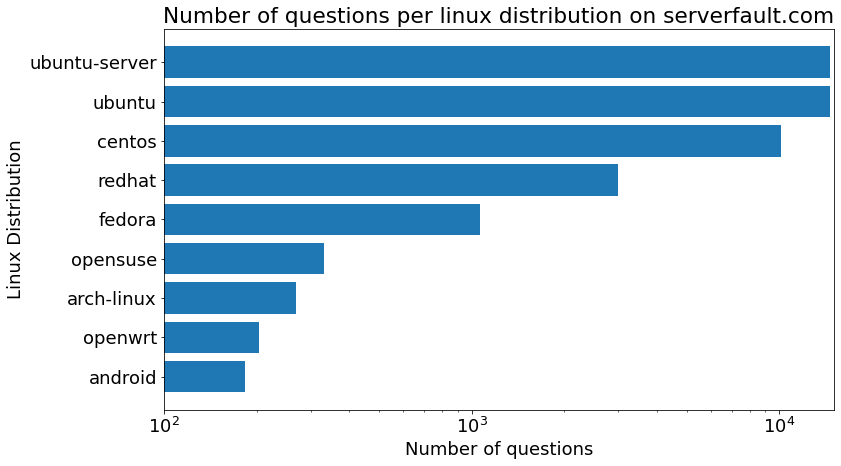

In [2]:
import matplotlib.pyplot as plt

# sorting data
distro_df.sort_values('num_questions', ascending=False, inplace=True)

# dropping any distro that has fewer than 100 questions on it
shortlist = distro_df[distro_df['num_questions'] > 100]

# data we want
names = shortlist['tag']
num_questions = shortlist['num_questions']

### plot data
# font size
plt.rcParams.update({'font.size': 18})

# figure
fig = plt.figure(figsize=(12, 7))

ax = plt.subplot()

# cosmetic
ax.set_ylabel('Linux Distribution')
ax.set_xlabel('Number of questions')
ax.set_title('Number of questions per linux distribution on serverfault.com')

# functional
ax.invert_yaxis()
ax.set_xscale('log')
ax.set_xlim([100, 15000])

# create plot
ax.barh(names, num_questions)

plt.show()